In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import display, HTML
import pandas as pd
from tqdm.auto import tqdm
import nltk
from nltk.tokenize import word_tokenize

def enhanced_word_importance(model, tokenizer, comment, context='', model_path=None, device='cuda',
                            visualization_type='all', save_path='word_importance_analysis'):
    """
    Advanced word importance analysis for sarcasm detection with multiple visualization methods
    
    Args:
        model: The sarcasm detection model (or None if model_path is provided)
        tokenizer: RoBERTa tokenizer
        comment: The comment text to analyze
        context: The context for the comment (optional)
        model_path: Path to load model from (optional)
        device: Device to run model on ('cuda' or 'cpu')
        visualization_type: Type of visualization ('individual', 'pairs', 'heatmap', 'all')
        save_path: Base path to save visualization files
    
    Returns:
        Dictionary with analysis results
    """
    # Ensure nltk tokenizer is available
    try:
        nltk.data.find('tokenizers/punkt')
    except LookupError:
        nltk.download('punkt')
    
    # Load model if path provided
    if model_path and model is None:
        model = SarcasmGCNLSTMDetector().to(device)
        model.load_state_dict(torch.load(model_path, map_location=device))
    
    model.eval()
    
    # Format input like during training
    if isinstance(context, list):
        context = " ".join([str(c) for c in context if c])
    
    # Check if context is empty and handle appropriately
    if context.strip():
        combined_text = f"Context: {context} Comment: {comment}"
    else:
        combined_text = f"Comment: {comment}"
    
    # Tokenize input
    encoding = tokenizer(
        combined_text,
        truncation=True,
        padding='max_length',
        max_length=128,
        return_tensors='pt'
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    # Create dataset instance for graph creation
    dummy_df = pd.DataFrame({'comment': [comment], 'context': [context], 'label': [0]})
    dataset = SarcasmGraphDataset(dummy_df, tokenizer)
    item = dataset[0]
    batch = collate_batch([item])
    
    graph_x = batch['graph_x'].to(device)
    graph_edge_index = batch['graph_edge_index'].to(device)
    
    # Get baseline prediction
    with torch.no_grad():
        baseline_output = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            graph_x=graph_x,
            graph_edge_index=graph_edge_index
        )
        baseline_prob = torch.sigmoid(baseline_output).item()
        prediction = baseline_prob > 0.5  # Boolean
    
    result = "Sarcastic" if prediction else "Not Sarcastic"  
    confidence = baseline_prob if prediction else 1 - baseline_prob
    
    print(f"\nBaseline Prediction: {result} (Confidence: {confidence:.4f})")
    
    # Extract words for analysis
    words = word_tokenize(comment)
    
    # 1. Individual Word Analysis (already in your code)
    word_impact = {}
    
    if visualization_type in ['individual', 'all']:
        print("\n1. Analyzing individual word importance...")
        
        for word in tqdm(words):
            # Create text with word removed
            modified_comment = comment.replace(word, "[MASK]")
            
            if isinstance(context, list):
                modified_context = context
            else:
                modified_context = [context]
            
            # Create new input
            if context.strip():
                modified_text = f"Context: {context} Comment: {modified_comment}"
            else:
                modified_text = f"Comment: {modified_comment}"
            
            modified_encoding = tokenizer(
                modified_text,
                truncation=True,
                padding='max_length',
                max_length=128,
                return_tensors='pt'
            )
            
            mod_input_ids = modified_encoding['input_ids'].to(device)
            mod_attention_mask = modified_encoding['attention_mask'].to(device)
            
            # Get prediction with word removed
            with torch.no_grad():
                modified_output = model(
                    input_ids=mod_input_ids,
                    attention_mask=mod_attention_mask,
                    graph_x=graph_x,
                    graph_edge_index=graph_edge_index
                )
                modified_prob = torch.sigmoid(modified_output).item()
            
            # Calculate impact (change in probability)
            impact = abs(baseline_prob - modified_prob)
            word_impact[word] = impact
        
        # Create individual word visualization
        plt.figure(figsize=(14, 8))
        
        # Word Impact by Removal Analysis
        words_list = list(word_impact.keys())
        impacts = list(word_impact.values())
        
        # Sort by impact
        sorted_indices = np.argsort(impacts)[::-1]
        sorted_words = [words_list[i] for i in sorted_indices]
        sorted_impacts = [impacts[i] for i in sorted_indices]
        
        # Create color gradient based on impact
        norm = plt.Normalize(0, max(sorted_impacts))
        colors = [plt.cm.viridis(norm(impact)) for impact in sorted_impacts]
        
        plt.bar(range(len(sorted_words)), sorted_impacts, color=colors)
        plt.xticks(range(len(sorted_words)), sorted_words, rotation=45, ha='right')
        plt.title('Word Impact Analysis: Effect of Removing Each Word on Prediction')
        plt.xlabel('Word')
        plt.ylabel('Impact (Change in Prediction Probability)')
        
        plt.tight_layout()
        plt.savefig(f'{save_path}_individual.png', dpi=300, bbox_inches='tight')
        
        # Print top impactful words
        print("\nTop 5 most important words:")
        for i in range(min(5, len(sorted_words))):
            print(f"{sorted_words[i]}: {sorted_impacts[i]:.4f}")
    
    # 2. Word Pairs Analysis
    word_pair_impact = {}
    
    if visualization_type in ['pairs', 'all']:
        print("\n2. Analyzing word pair importance...")
        
        # Generate all adjacent word pairs
        word_pairs = [(words[i], words[i+1]) for i in range(len(words)-1)]
        
        for pair in tqdm(word_pairs):
            pair_text = f"{pair[0]} {pair[1]}"
            
            # Create text with pair removed
            modified_comment = comment.replace(pair_text, "[MASK]")
            
            # Create new input
            if context.strip():
                modified_text = f"Context: {context} Comment: {modified_comment}"
            else:
                modified_text = f"Comment: {modified_comment}"
            
            modified_encoding = tokenizer(
                modified_text,
                truncation=True,
                padding='max_length',
                max_length=128,
                return_tensors='pt'
            )
            
            mod_input_ids = modified_encoding['input_ids'].to(device)
            mod_attention_mask = modified_encoding['attention_mask'].to(device)
            
            # Get prediction with word pair removed
            with torch.no_grad():
                modified_output = model(
                    input_ids=mod_input_ids,
                    attention_mask=mod_attention_mask,
                    graph_x=graph_x,
                    graph_edge_index=graph_edge_index
                )
                modified_prob = torch.sigmoid(modified_output).item()
            
            # Calculate impact (change in probability)
            impact = abs(baseline_prob - modified_prob)
            word_pair_impact[pair_text] = impact
        
        # Create word pairs visualization
        plt.figure(figsize=(14, 8))
        
        # Word Pair Impact by Removal Analysis
        pairs_list = list(word_pair_impact.keys())
        pair_impacts = list(word_pair_impact.values())
        
        # Sort by impact
        pair_sorted_indices = np.argsort(pair_impacts)[::-1]
        sorted_pairs = [pairs_list[i] for i in pair_sorted_indices]
        sorted_pair_impacts = [pair_impacts[i] for i in pair_sorted_indices]
        
        # Create color gradient based on impact
        norm = plt.Normalize(0, max(sorted_pair_impacts))
        colors = [plt.cm.plasma(norm(impact)) for impact in sorted_pair_impacts]
        
        plt.bar(range(len(sorted_pairs)), sorted_pair_impacts, color=colors)
        plt.xticks(range(len(sorted_pairs)), sorted_pairs, rotation=45, ha='right')
        plt.title('Word Pair Analysis: Effect of Removing Adjacent Word Pairs on Prediction')
        plt.xlabel('Word Pair')
        plt.ylabel('Impact (Change in Prediction Probability)')
        
        plt.tight_layout()
        plt.savefig(f'{save_path}_pairs.png', dpi=300, bbox_inches='tight')
        
        # Print top impactful word pairs
        print("\nTop 5 most important word pairs:")
        for i in range(min(5, len(sorted_pairs))):
            print(f"{sorted_pairs[i]}: {sorted_pair_impacts[i]:.4f}")
    
    # 3. Comparative Word Heatmap
    if visualization_type in ['heatmap', 'all']:
        print("\n3. Creating word importance heatmap...")
        
        # Create a matrix of word removals (how removing word i affects predictions when word j is already removed)
        n_words = len(words)
        impact_matrix = np.zeros((n_words, n_words))
        
        # This is computationally intensive, so we'll do a subset of all possible combinations
        for i in tqdm(range(min(n_words, 10))):  # Limit to first 10 words for computational efficiency
            word_i = words[i]
            
            # First, remove word_i
            comment_without_i = comment.replace(word_i, "[MASK]")
            
            for j in range(i+1, min(n_words, 10)):  # Only analyze combinations, not permutations
                word_j = words[j]
                
                # Remove both words
                comment_without_both = comment_without_i.replace(word_j, "[MASK]")
                
                # Create new input
                if context.strip():
                    modified_text = f"Context: {context} Comment: {comment_without_both}"
                else:
                    modified_text = f"Comment: {comment_without_both}"
                
                modified_encoding = tokenizer(
                    modified_text,
                    truncation=True,
                    padding='max_length',
                    max_length=128,
                    return_tensors='pt'
                )
                
                mod_input_ids = modified_encoding['input_ids'].to(device)
                mod_attention_mask = modified_encoding['attention_mask'].to(device)
                
                # Get prediction with both words removed
                with torch.no_grad():
                    modified_output = model(
                        input_ids=mod_input_ids,
                        attention_mask=mod_attention_mask,
                        graph_x=graph_x,
                        graph_edge_index=graph_edge_index
                    )
                    modified_prob = torch.sigmoid(modified_output).item()
                
                # Calculate interaction impact
                # Higher value means removing both has stronger effect than removing individually
                individual_impact = word_impact.get(word_i, 0) + word_impact.get(word_j, 0)
                combined_impact = abs(baseline_prob - modified_prob)
                
                # If combined_impact > individual_impact, there's a synergistic effect
                # If combined_impact < individual_impact, there's a redundancy effect
                interaction_score = combined_impact - individual_impact
                
                impact_matrix[i, j] = interaction_score
                impact_matrix[j, i] = interaction_score  # Symmetric matrix
        
        # Only use the words that were actually analyzed
        analyzed_words = words[:min(n_words, 10)]
        
        # Create heatmap visualization
        plt.figure(figsize=(12, 10))
        
        # Create a custom colormap for word interactions
        c = ['#5AD0FC', '#FFFFFF', '#FC5A5A']  # Blue for negative, white for neutral, red for positive
        v = [-np.max(np.abs(impact_matrix)), 0, np.max(np.abs(impact_matrix))]
        custom_cmap = LinearSegmentedColormap.from_list('custom_diverging', list(zip(np.linspace(0, 1, 3), c)))
        
        # Plot heatmap
        sns.heatmap(impact_matrix[:len(analyzed_words), :len(analyzed_words)],
                   cmap=custom_cmap,
                   vmin=-np.max(np.abs(impact_matrix)), vmax=np.max(np.abs(impact_matrix)),
                   xticklabels=analyzed_words,
                   yticklabels=analyzed_words,
                   annot=True, fmt=".2f", linewidths=0.5)
        
        plt.title('Word Interaction Heatmap\n(Positive values = synergistic effect, Negative = redundant effect)')
        plt.tight_layout()
        plt.savefig(f'{save_path}_heatmap.png', dpi=300, bbox_inches='tight')
    
    # 4. HTML Visualization
    print("\n4. Creating interactive HTML visualization...")
    
    # Normalize word_impact for visualization
    max_impact = max(word_impact.values()) if word_impact else 1.0
    normalized_impact = {word: impact/max_impact for word, impact in word_impact.items()}
    
    # Create HTML representation for visualization in notebooks
    html_text = ""
    for word in words:
        if word in normalized_impact:
            importance = normalized_impact[word]
            opacity = min(1.0, 0.3 + importance * 0.7)
            # Create HTML span with background color
            if prediction:  # Sarcastic
                html_text += f'<span style="background-color: rgba(255, 0, 0, {opacity}); padding: 2px 4px; margin: 2px; border-radius: 3px;">{word}</span> '
            else:  # Not sarcastic
                html_text += f'<span style="background-color: rgba(0, 0, 255, {opacity}); padding: 2px 4px; margin: 2px; border-radius: 3px;">{word}</span> '
        else:
            html_text += f"{word} "
    
    # Create description for visualization
    if prediction:
        explanation = "Words highlighted in <span style='background-color: rgba(255, 0, 0, 0.7); padding: 2px 4px; border-radius: 3px;'>darker red</span> contribute more to the sarcastic classification"
    else:
        explanation = "Words highlighted in <span style='background-color: rgba(0, 0, 255, 0.7); padding: 2px 4px; border-radius: 3px;'>darker blue</span> contribute more to the non-sarcastic classification"
    
    # Create interactive HTML
    html_output = f"""
    <!DOCTYPE html>
    <html>
    <head>
        <title>Sarcasm Detection Analysis</title>
        <style>
            body {{ font-family: Arial, sans-serif; margin: 20px; }}
            .container {{ border: 1px solid #ccc; padding: 20px; border-radius: 5px; }}
            .result {{ font-size: 18px; font-weight: bold; margin-bottom: 10px; }}
            .text {{ line-height: 2; font-size: 16px; margin: 15px 0; }}
            .explanation {{ font-size: 14px; color: #666; }}
        </style>
    </head>
    <body>
        <div class="container">
            <div class="result">Prediction: {result} (Confidence: {confidence:.2f})</div>
            <div class="text">{html_text}</div>
            <div class="explanation">{explanation}</div>
        </div>
    </body>
    </html>
    """
    
    # Save HTML file
    with open(f'{save_path}_visualization.html', 'w') as f:
        f.write(html_output)
    
    # Display in Jupyter notebook if available
    try:
        from IPython.display import display, HTML
        display(HTML(html_output))
    except:
        print("HTML visualization saved to file. Open in a browser to view.")
    
    # Return analysis results
    return {
        'result': result,
        'confidence': confidence,
        'word_impact': word_impact,
        'word_pair_impact': word_pair_impact if visualization_type in ['pairs', 'all'] else None,
        'impact_matrix': impact_matrix if visualization_type in ['heatmap', 'all'] else None,
        'sorted_words': sorted_words if visualization_type in ['individual', 'all'] else None,
        'sorted_impacts': sorted_impacts if visualization_type in ['individual', 'all'] else None,
        'html_visualization': html_output
    }


# enhanced_word_importance(model, tokenizer, "This restaurant is absolutely amazing, worst experience ever!", 
#                         visualization_type='all', save_path='sarcasm_analysis')

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import (
    RobertaTokenizer,
    RobertaModel,
    # AdamW,
    get_linear_schedule_with_warmup,
)
from torch.optim import AdamW
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    f1_score,
    confusion_matrix,
)
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import ast
import os
import gc
import networkx as nx
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize
from sklearn.utils import resample
import spacy
from senticnet.senticnet import SenticNet
import gensim.downloader as gensim_downloader

print("Loading GloVe embeddings...")
try:
    glove_embeddings = gensim_downloader.load("glove-wiki-gigaword-300")
    EMBEDDING_DIM = 300
    print(f"Loaded GloVe embeddings with dimension: {EMBEDDING_DIM}")
except Exception as e:
    print(f"Error loading GloVe embeddings: {str(e)}")
    print("Using random embeddings instead")
    glove_embeddings = None
    EMBEDDING_DIM = 300

# Load spaCy model
try:
    nlp = spacy.load("en_core_web_sm")
    print("Loaded spaCy model successfully")
except:
    print("Downloading spaCy model...")
    import subprocess

    subprocess.run(["python", "-m", "spacy", "download", "en_core_web_sm"])
    nlp = spacy.load("en_core_web_sm")

# Initialize SenticNet
try:
    sn = SenticNet()
    print("Loaded SenticNet successfully")
except Exception as e:
    print(f"Error loading SenticNet: {str(e)}")
    sn = None

class SarcasmGraphDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=128):
        self.tokenizer = tokenizer
        self.comments = df["comment"].values
        self.contexts = df["context"].values
        self.labels = df["label"].values
        self.max_length = max_length
        self.window_size = 2  # Window size for graph construction

    def __len__(self):
        return len(self.comments)

    def get_embedding(self, word):
        """Get the GloVe embedding for a word"""
        word = word.lower()
        if glove_embeddings and word in glove_embeddings:
            return torch.tensor(glove_embeddings[word], dtype=torch.float)
        else:
            # Use random embedding if word not found
            return torch.randn(EMBEDDING_DIM, dtype=torch.float)

    def get_sentiment_features(self, word):
        """Extract sentiment features using SenticNet"""
        try:
            if sn is not None:
                concept_info = sn.concept(word)
                # Extract polarity value (float between -1 and 1)
                polarity = float(concept_info["polarity_value"])
                # Create a 5-dimensional feature: [polarity, is_positive, is_negative, is_neutral, intensity]
                is_positive = 1.0 if polarity > 0.1 else 0.0
                is_negative = 1.0 if polarity < -0.1 else 0.0
                is_neutral = 1.0 if abs(polarity) <= 0.1 else 0.0
                intensity = abs(polarity)
                return torch.tensor(
                    [polarity, is_positive, is_negative, is_neutral, intensity],
                    dtype=torch.float,
                )
            else:
                return torch.zeros(5, dtype=torch.float)
        except:
            # Word not found in SenticNet
            return torch.zeros(5, dtype=torch.float)

    def create_graph_from_text(self, text):
        """Create a graph representation of text for GCN with enhanced features"""
        # Parse text with spaCy for dependency parsing
        doc = nlp(text.lower())

        # Create a graph where nodes are tokens
        G = nx.Graph()

        # Store tokens for later embedding lookup
        tokens = [token.text for token in doc]

        # Add nodes with positions
        for i, token in enumerate(doc):
            G.add_node(i, word=token.text, pos=token.pos_)

        # Add edges based on window and dependencies
        # 1. Window-based edges
        for i in range(len(tokens)):
            for j in range(i + 1, min(i + self.window_size + 1, len(tokens))):
                G.add_edge(i, j, edge_type=0)  # Type 0: window edge

        # 2. Dependency-based edges
        for token in doc:
            if token.i < len(tokens) and token.head.i < len(tokens):
                G.add_edge(
                    token.i, token.head.i, edge_type=1
                )  # Type 1: dependency edge

        # Convert to PyTorch Geometric Data object
        if len(G.nodes) > 0:
            data = from_networkx(G)

            # Create feature matrix for nodes [GloVe (25d) + Sentiment (5d)]
            feature_dim = EMBEDDING_DIM + 5
            features = torch.zeros((len(G.nodes), feature_dim), dtype=torch.float)

            for i, token_text in enumerate(tokens):
                if i < len(features):
                    # GloVe embedding
                    glove_feature = self.get_embedding(token_text)
                    # Sentiment features
                    sentiment_feature = self.get_sentiment_features(token_text)
                    # Concatenate features
                    if (
                        len(glove_feature) == EMBEDDING_DIM
                        and len(sentiment_feature) == 5
                    ):
                        features[i] = torch.cat([glove_feature, sentiment_feature])

            data.x = features
            return data, tokens
        else:
            # Return empty graph if there are no nodes
            empty_data = Data(
                x=torch.zeros((1, feature_dim), dtype=torch.float),
                edge_index=torch.zeros((2, 0), dtype=torch.long),
            )
            return empty_data, []

    def __getitem__(self, idx):
        comment = str(self.comments[idx])

        # Parse context if it's a string
        if isinstance(self.contexts[idx], str):
            try:
                context_list = ast.literal_eval(self.contexts[idx])
            except:
                context_list = [self.contexts[idx]]
        else:
            context_list = self.contexts[idx]

        # Join all context elements
        context = " ".join([str(c) for c in context_list])

        # Combine context and comment
        combined_text = f"Context: {context} Comment: {comment}"

        # Create graph data with enhanced features
        graph_data, tokens = self.create_graph_from_text(combined_text)

        # Encode with truncation and padding for transformer
        encoding = self.tokenizer(
            combined_text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt",
        )

        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "graph_data": graph_data,
            "tokens": tokens,
            "label": torch.tensor(self.labels[idx], dtype=torch.float),
        }

class GCNLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(GCNLayer, self).__init__()
        self.gc = GCNConv(in_features, out_features)
        self.bn = nn.BatchNorm1d(out_features)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x, edge_index):
        x = self.gc(x, edge_index)
        if x.size(0) > 1:  # BatchNorm needs more than 1 element
            x = self.bn(x)
        x = F.relu(x)
        return self.dropout(x)


class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=1, bidirectional=True):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers,
            batch_first=True,
            bidirectional=bidirectional,
        )

    def forward(self, x):
        # x shape: (batch, seq_len, input_dim)
        lstm_out, _ = self.lstm(x)
        # Get the output from the last non-padded element
        last_output = lstm_out[:, -1, :]
        return last_output


class SarcasmGCNLSTMDetector(nn.Module):
    def __init__(
        self, pretrained_model="roberta-base", gcn_hidden_dim=64, dropout_rate=0.3
    ):
        super(SarcasmGCNLSTMDetector, self).__init__()
        self.roberta = RobertaModel.from_pretrained(pretrained_model)
        self.hidden_dim = self.roberta.config.hidden_size

        # Feature dimensions
        feature_dim = EMBEDDING_DIM + 5  # GloVe + Sentiment

        # 4-layer GCN as per the paper
        self.gcn1 = GCNLayer(feature_dim, gcn_hidden_dim)
        self.gcn2 = GCNLayer(gcn_hidden_dim, gcn_hidden_dim * 2)
        self.gcn3 = GCNLayer(gcn_hidden_dim * 2, gcn_hidden_dim * 2)
        self.gcn4 = GCNLayer(gcn_hidden_dim * 2, gcn_hidden_dim)

        # LSTM for sequential processing
        self.lstm = LSTM(gcn_hidden_dim, gcn_hidden_dim // 2, bidirectional=True)

        # Attention mechanism for combining RoBERTa and GCN-LSTM outputs
        self.attention = nn.Linear(self.hidden_dim + gcn_hidden_dim, 1)

        # Final classification layers
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(self.hidden_dim + gcn_hidden_dim, 256)
        self.fc2 = nn.Linear(256, 1)

    def forward(self, input_ids, attention_mask, graph_x, graph_edge_index):
        # Process text with RoBERTa
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        roberta_embedding = outputs.pooler_output  # [CLS] token embedding

        # Process graph with multi-layer GCN
        x1 = self.gcn1(graph_x, graph_edge_index)
        x2 = self.gcn2(x1, graph_edge_index)
        x3 = self.gcn3(x2, graph_edge_index)
        x4 = self.gcn4(x3, graph_edge_index)

        # Prepare for LSTM - reshape if there's a batch
        batch_size = roberta_embedding.shape[0]
        if batch_size > 1:
            # For simplicity, we'll just take the mean of the node embeddings for batched graphs
            gcn_embedding = torch.mean(x4, dim=0).unsqueeze(0)
            gcn_embedding = gcn_embedding.expand(batch_size, -1)
        else:
            # Use LSTM for sequential processing (for single example)
            # Reshape for LSTM: [num_nodes, features] -> [1, num_nodes, features]
            lstm_input = x4.unsqueeze(0)
            gcn_embedding = self.lstm(lstm_input)

        # Concatenate RoBERTa and GCN-LSTM embeddings
        combined = torch.cat((roberta_embedding, gcn_embedding), dim=1)

        # Apply attention
        attention_weights = torch.sigmoid(self.attention(combined))
        weighted_embedding = combined * attention_weights

        # Final classification
        x = self.dropout(weighted_embedding)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        # Output logits (not sigmoid)
        return self.fc2(x)

Loading GloVe embeddings...
Loaded GloVe embeddings with dimension: 300
Loaded spaCy model successfully
Loaded SenticNet successfully


In [4]:
def collate_batch(batch):
    """Custom collate function for handling graph data"""
    # Extract elements from batch
    input_ids = torch.stack([item["input_ids"] for item in batch])
    attention_mask = torch.stack([item["attention_mask"] for item in batch])
    labels = torch.stack([item["label"] for item in batch])
    tokens_list = [item["tokens"] for item in batch]

    # For graph data, we create a simple representation with batch size of 1
    # In a production system, you would use proper batching from PyG
    graph_xs = [item["graph_data"].x for item in batch]
    graph_edge_indices = [item["graph_data"].edge_index for item in batch]

    # Use the first graph for simplicity (or you could merge graphs with proper shifts)
    feature_dim = EMBEDDING_DIM + 5  # GloVe + Sentiment
    if len(graph_xs) > 0 and graph_xs[0] is not None and graph_xs[0].numel() > 0:
        graph_x = graph_xs[0]
        graph_edge_index = graph_edge_indices[0]
    else:
        # Fallback for empty graphs
        graph_x = torch.zeros((1, feature_dim), dtype=torch.float)
        graph_edge_index = torch.zeros((2, 0), dtype=torch.long)

    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "graph_x": graph_x,
        "graph_edge_index": graph_edge_index,
        "tokens": tokens_list,
        "label": labels,
    }


Loading model from ../sarcasm_gcn_lstm_detector_best.pt...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully!

Baseline Prediction: Sarcastic (Confidence: 0.9587)

1. Analyzing individual word importance...


  0%|          | 0/16 [00:00<?, ?it/s]


Top 5 most important words:
any: 0.3041
on: 0.2068
moving: 0.1851
minute: 0.1249
will: 0.1220

2. Analyzing word pair importance...


  0%|          | 0/15 [00:00<?, ?it/s]


Top 5 most important word pairs:
sure glaciers: 0.4503
moving any: 0.4354
any minute: 0.1464
minute now: 0.1380
start moving: 0.0643

3. Creating word importance heatmap...


  0%|          | 0/10 [00:00<?, ?it/s]


4. Creating interactive HTML visualization...


{'result': 'Sarcastic', 'confidence': 0.958747148513794, 'word_impact': {'Congratulations': 0.027636051177978516, 'on': 0.20680582523345947, 'stating': 0.0012853741645812988, 'the': 0.01571178436279297, 'obvious': 0.014466047286987305, '.': 0.014310836791992188, 'I': 0.0018649697303771973, 'am': 0.013958454132080078, 'sure': 0.08148312568664551, 'glaciers': 0.02513885498046875, 'will': 0.12202084064483643, 'start': 0.08522671461105347, 'moving': 0.18508166074752808, 'any': 0.3041170835494995, 'minute': 0.12486547231674194, 'now': 0.10788172483444214}, 'word_pair_impact': {'Congratulations on': 0.012485146522521973, 'on stating': 0.0010040998458862305, 'stating the': 0.02412205934524536, 'the obvious': 0.016645491123199463, 'obvious .': 0.0, '. I': 0.0031890869140625, 'I am': 0.02591264247894287, 'am sure': 0.04009610414505005, 'sure glaciers': 0.4503156542778015, 'glaciers will': 0.05779606103897095, 'will start': 0.03357672691345215, 'start moving': 0.06429582834243774, 'moving any': 

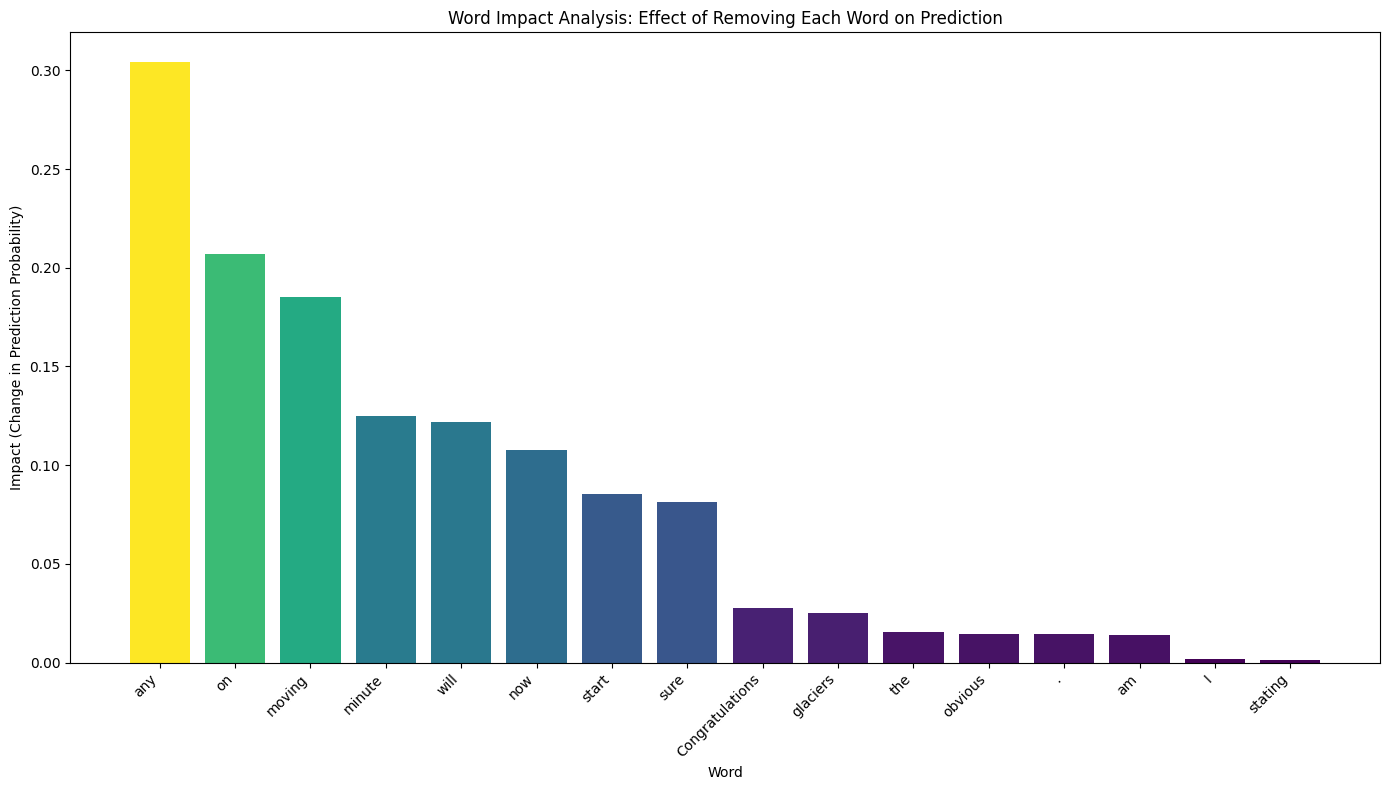

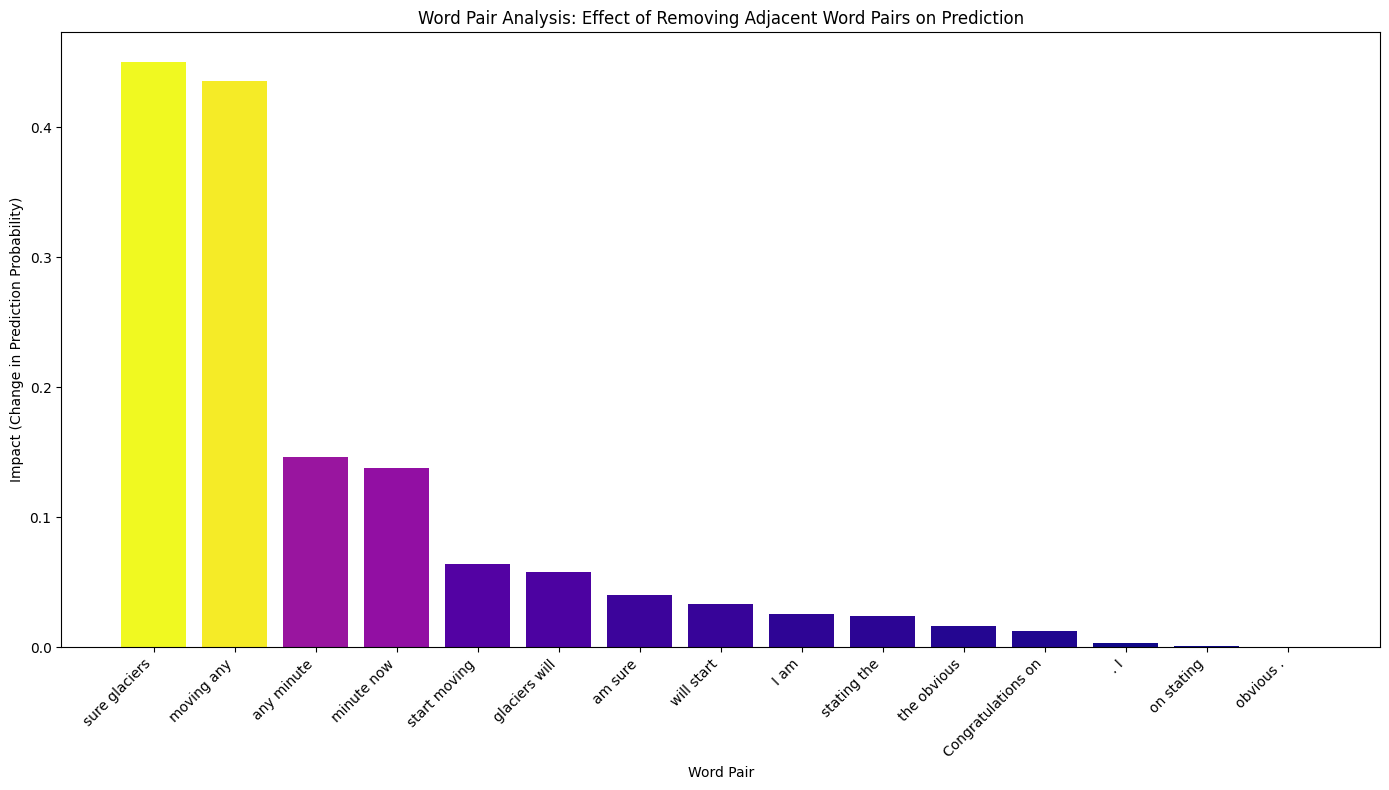

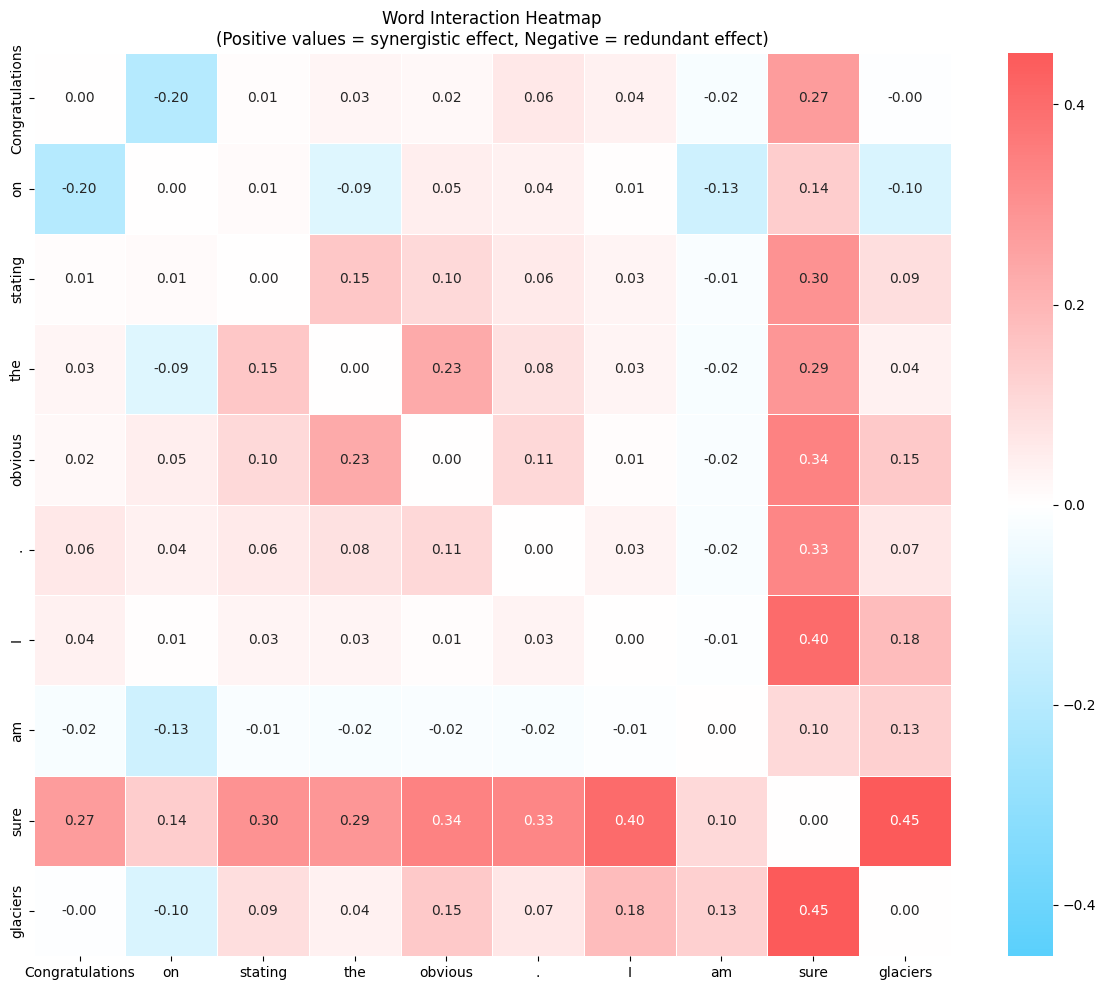

In [5]:
MODEL_PATH = "../sarcasm_gcn_lstm_detector_best.pt"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_model_and_tokenizer():
    """Load the sarcasm detection model and tokenizer"""
    print(f"Loading model from {MODEL_PATH}...")
    
    # Initialize tokenizer
    tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
    
    # Initialize model
    model = SarcasmGCNLSTMDetector().to(DEVICE)
    
    # Load trained weights
    if os.path.exists(MODEL_PATH):
        model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
        print("Model loaded successfully!")
    else:
        print(f"Warning: Model file not found at {MODEL_PATH}")
    
    model.eval()  # Set model to evaluation mode
    
    return model, tokenizer

model, tokenizer = load_model_and_tokenizer()
# Example usage
comment = "Congratulations on stating the obvious. I am sure glaciers will start moving any minute now"
# context = I we"nt there last week."
# comment = "I love waiting in line for hours"
visualization_type = 'all'
save_path = 'sarcasm_analysis'
result = enhanced_word_importance(
    model,
    tokenizer,
    comment,
    # context=context,
    visualization_type=visualization_type,
    save_path=save_path
)
print(result)
